In [1]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [2]:
!pip install tensorflow


In [3]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, Dropout, Add, BatchNormalization
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.applications import ResNet50

In [4]:
# Set paths
image_folder = '/content/Flicker8k_Dataset'
captions_path = '/content/Flickr8k.token.txt'

# Load captions into a dictionary
def load_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as f:
        for line in f:
            line = line.strip()
            img_id, caption = line.split('\t')
            img_id = img_id.split('#')[0]
            if img_id not in captions_dict:
                captions_dict[img_id] = []
            captions_dict[img_id].append(caption)
    return captions_dict

# Load captions
captions_dict = load_captions(captions_path)



In [5]:
#now extracting the image features using vresnet
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
#restructuring the model (-2 3shan e7na msh 3ayzen el classification elly fel a5er 3ayzen bas n-extract)

#printing the summary of the model we loaded
print(model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


In [6]:
import random

data_features = {}

# Directory containing images
dirc = os.path.join(image_folder)

# List all images in the directory
all_images = os.listdir(dirc)

# Calculate 15% of the total images
num_images_to_select = int(len(all_images) * 1)

# Randomly sample 15% of the images
selected_images = random.sample(all_images, num_images_to_select)

for img_name in tqdm(selected_images):
    filename = os.path.join(dirc, img_name)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # Preprocessing the images to input into the model
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]

    data_features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [7]:
# store the features extracted 3shan msh kol marra y-extract
pickle.dump(data_features, open('features.pkl', 'wb'))

In [8]:
#loading the features mn el pickle just to make sure
with open('features.pkl', 'rb') as File:
    data_features = pickle.load(File)

In [9]:
mapping ={}

#processing lines:
for line in tqdm(open(captions_path, 'r')):
  tokens = line.split()
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  image_id = image_id.split('.')[0]
  caption = " ".join(caption)

  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)



len(mapping)


0it [00:00, ?it/s]

8092

In [10]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
import re

In [12]:
#preprocessing the text data
def cleanCaptions(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = re.sub(r'[^a-z\s]', '', caption)  # Keep only letters and spaces
            caption = re.sub(r'\s+', ' ', caption)       # Replace multiple spaces with single space
            caption = caption.strip()                   # Remove leading/trailing spaces
            caption = '<start> ' + caption + ' <end>'
            captions[i] = caption

# Call cleanCaptions again after fixing
cleanCaptions(mapping)


In [13]:
mapping['1000268201_693b08cb0e']

['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
 '<start> a girl going into a wooden building <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a little girl climbing the stairs to her playhouse <end>',
 '<start> a little girl in a pink dress going into a wooden cabin <end>']

In [14]:
captions = []
for key in mapping:
  for caption in mapping[key]:
    captions.append(caption)

len(captions)

40460

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
Vocab = len(tokenizer.word_index) + 1

print(Vocab)

8779


In [16]:
max_len = max(len(caption.split()) for caption in captions)
print(f'Max caption length: {max_len}')

Max caption length: 37


In [17]:
img_ids = list(mapping.keys())
split = int(len(img_ids)*0.80)

train = img_ids[:split]
test = img_ids[split:]

In [18]:
#3shan el session may7slhash crash bne-process el data seq by seq
def generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            captions = mapping.get(key, [])  # get captions wel default to empty list if missing
            image_feature = features.get(key)  #  get features for the image
            if image_feature is None:  # Skip if the feature is missing
                continue
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(image_feature[0])  # Use the feature for the image
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                X1 = tf.convert_to_tensor(np.array(X1), dtype=tf.float32)  # Image features: (batch_size, 4096)
                X2 = tf.convert_to_tensor(np.array(X2), dtype=tf.int32)    # Sequence data: (batch_size, max_len)
                y = tf.convert_to_tensor(np.array(y), dtype=tf.float32)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 37, 256)   │  2,247,424 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 37, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 256)       │    394,752 │ dropout_1[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8779)      │  2,256,203 │ gru[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,423,947 (20.69 MB)

 Trainable params: 5,423,435 (20.69 MB)

 Non-trainable params: 512 (2.00 KB)

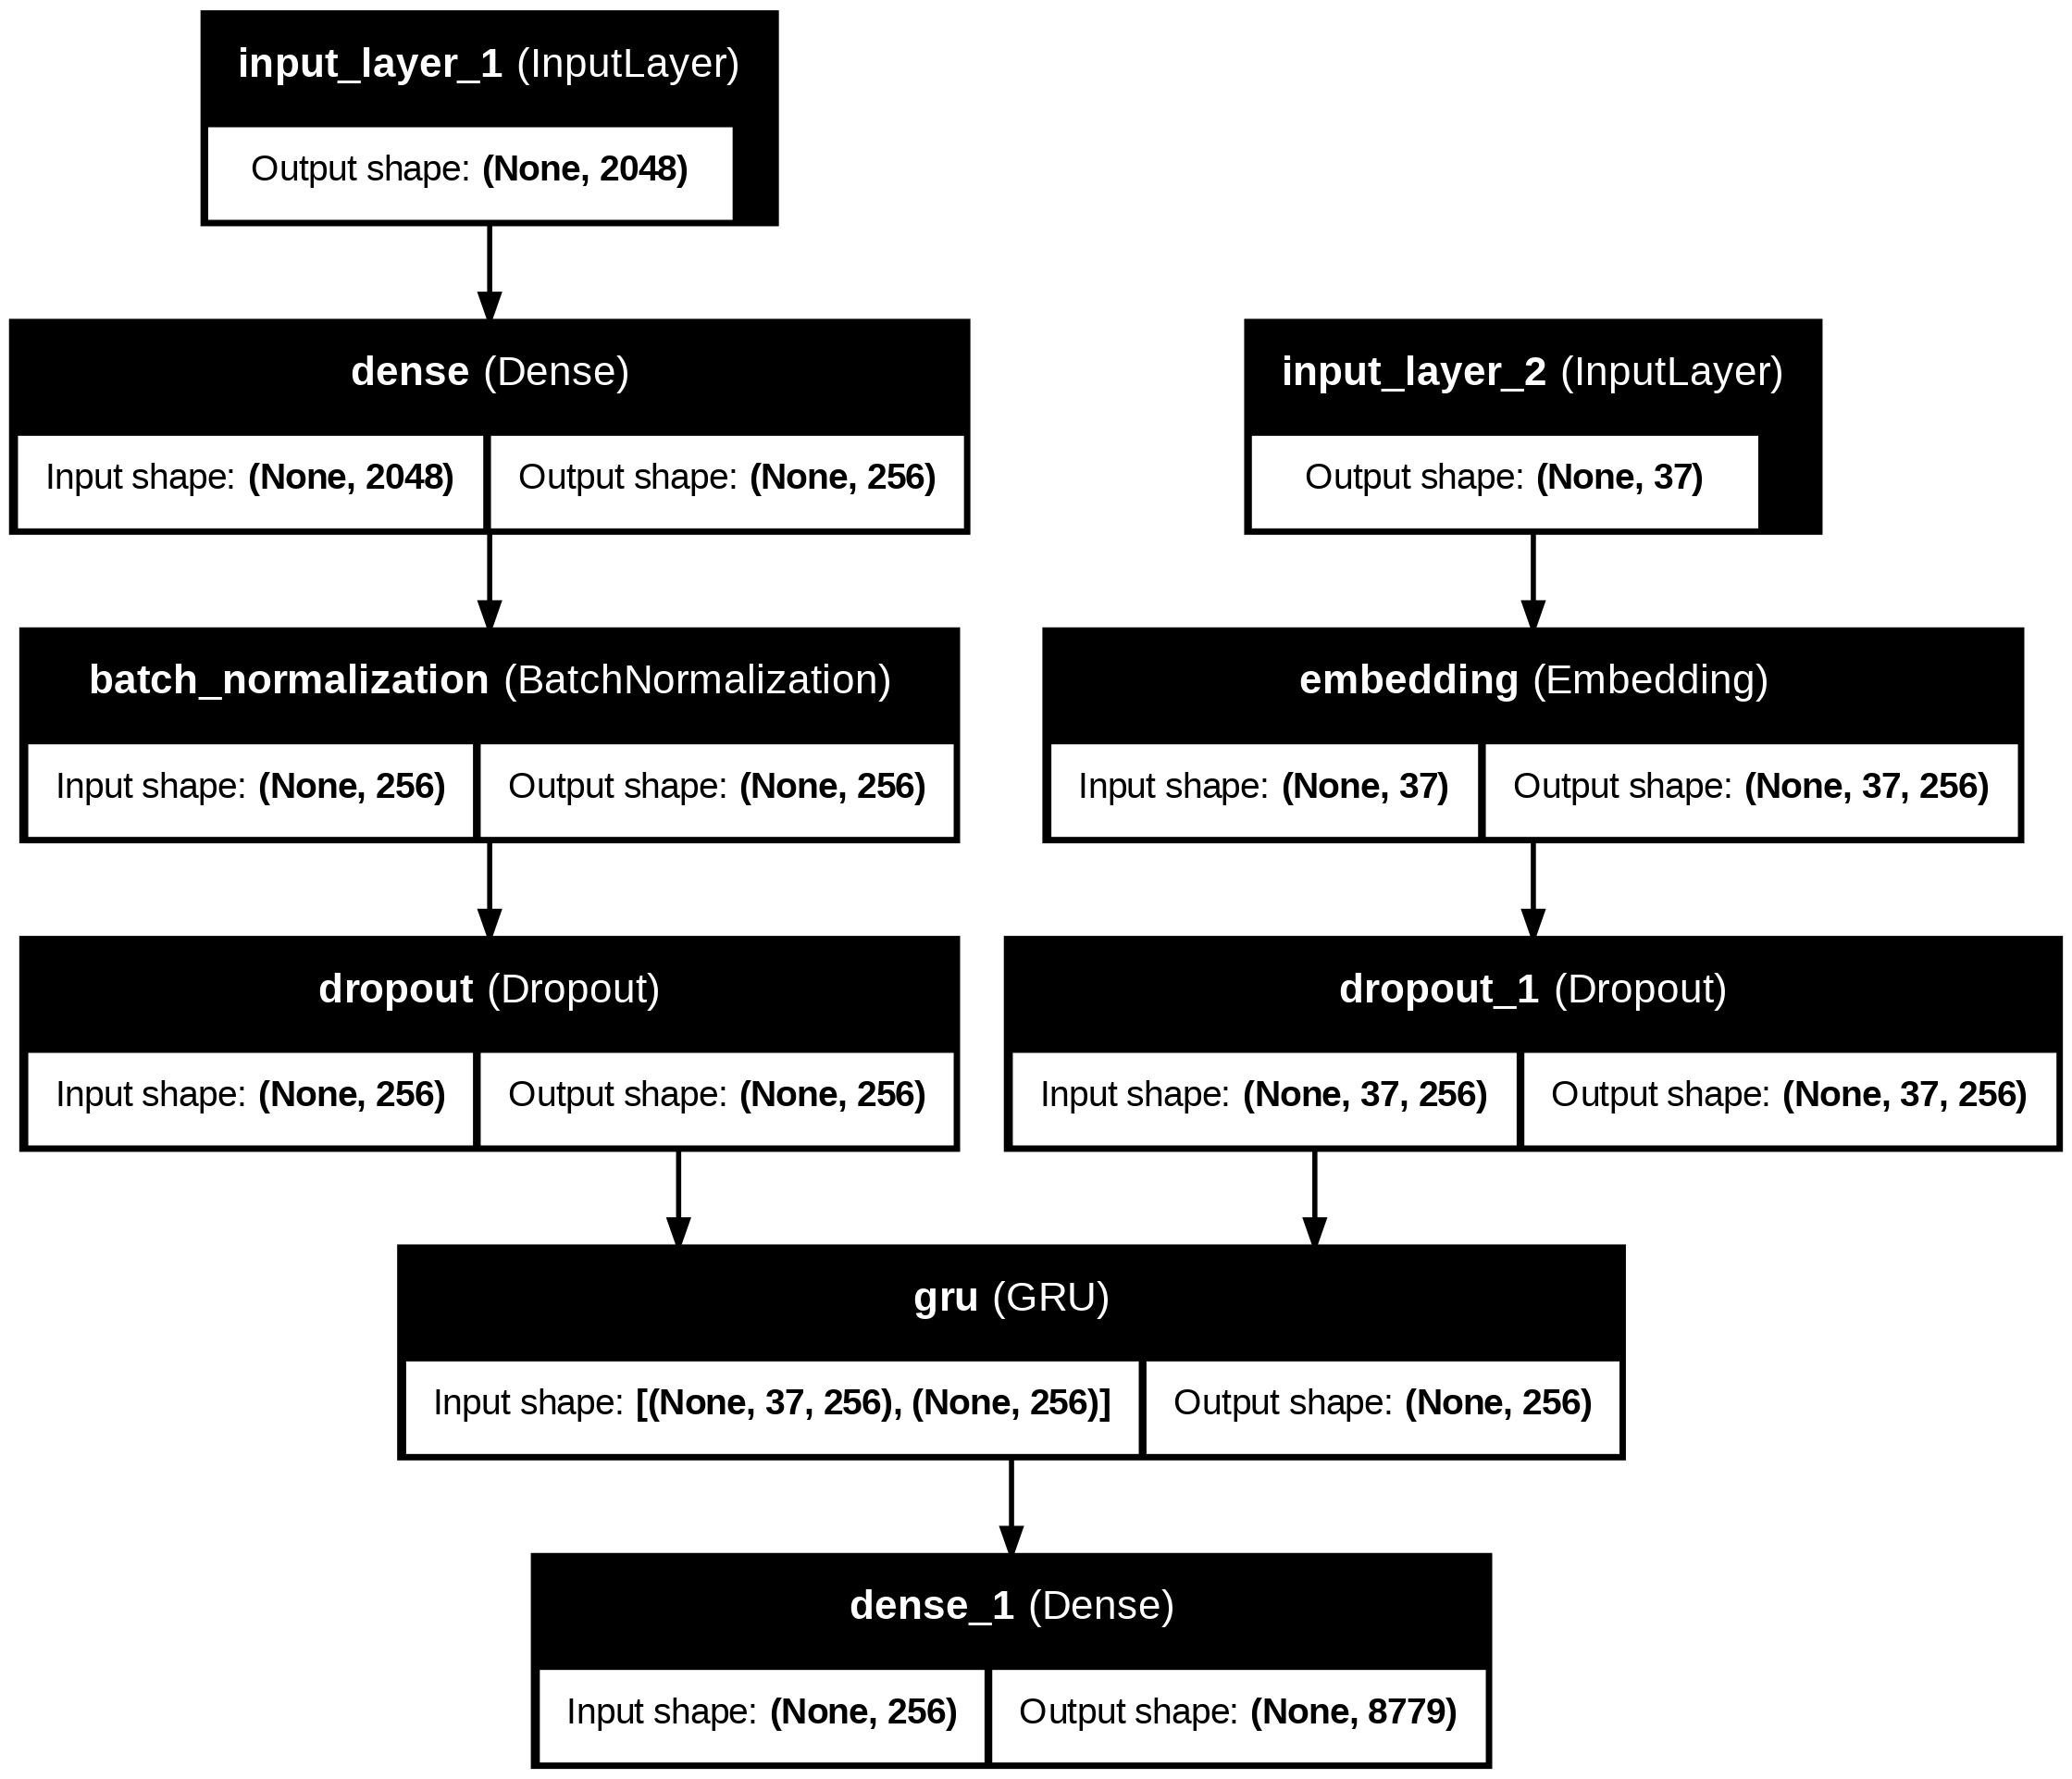

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Embedding, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Define model creation function
def create_gru_model(Vocab, max_len, embedding_dim=256, gru_units=256, dropout_rate=0.4):
    # Encoder (Image Features)
    image_input = Input(shape=(2048,))
    img_features = Dense(gru_units, activation='relu')(image_input)
    img_features = BatchNormalization()(img_features)
    img_features = Dropout(dropout_rate)(img_features)

    # Decoder (Caption Input)
    caption_input = Input(shape=(max_len,))
    caption_embedding = Embedding(input_dim=Vocab, output_dim=embedding_dim, mask_zero=True)(caption_input)
    caption_embedding = Dropout(dropout_rate)(caption_embedding)

    # GRU layer (decoder)
    gru_layer = GRU(gru_units, return_sequences=False)
    decoder_output = gru_layer(caption_embedding, initial_state=img_features)

    # Output layer
    outputs = Dense(Vocab, activation='softmax')(decoder_output)

    # Build and compile model
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    optimizer = Adam(learning_rate=0.0005)

    # Optional: label smoothing
    loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

    model.compile(
        loss=loss_fn,
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Create the model
model = create_gru_model(Vocab, max_len)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)


In [24]:

# Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_gru_caption_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

train_generator = generator(train, mapping, data_features, tokenizer, max_len, Vocab, batch_size=32)
val_generator = generator(test, mapping, data_features, tokenizer, max_len, Vocab, batch_size=32)

steps_per_epoch = len(train)
val_steps = len(test)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=15,
    callbacks=callbacks
)


# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()


Epoch 1/15
6473/6473 ━━━━━━━━━━━━━━━━━━━━ 3683s 569ms/step - accuracy: 0.3972 - loss: 3.8856 - val_accuracy: 0.3954 - val_loss: 3.9562 - learning_rate: 5.0000e-04
Epoch 2/15
6473/6473 ━━━━━━━━━━━━━━━━━━━━ 3689s 570ms/step - accuracy: 0.4897 - loss: 3.2222 - val_accuracy: 0.3920 - val_loss: 4.0557 - learning_rate: 5.0000e-04
Epoch 3/15
 160/6473 ━━━━━━━━━━━━━━━━━━━━ 48:07 457ms/step - accuracy: 0.5233 - loss: 3.0293

KeyboardInterrupt: 

# All

In [25]:
# Save final model
model.save('final_caption_model resnet.h5')
print("✅ Final model saved as 'final_caption_model resnet.h5'")


✅ Final model saved as 'final_caption_model resnet.h5'


In [26]:
from keras.models import load_model
modell = load_model('final_caption_model resnet.h5')
modell.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 37, 256)   │  2,247,424 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 37, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 256)       │    394,752 │ dropout_1[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8779)      │  2,256,203 │ gru[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,423,949 (20.69 MB)

 Trainable params: 5,423,435 (20.69 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 2 (12.00 B)

In [31]:
def predict_caption(model, image_features, tokenizer, max_len):
    """
    Generate a caption for the given image features using the trained model.

    Args:
        model: The trained captioning model
        image_features: Extracted features from VGG16 (shape: (1, 4096))
        tokenizer: The tokenizer used during training
        max_len: Maximum length of captions

    Returns:
        str: Generated caption
    """
    # Start with the initial token
    in_text = '<start>'

    # Iterate until we predict the end token or reach max length
    for _ in range(max_len):
        # Convert current text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        # Predict next word
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get index with highest probability
        yhat = np.argmax(yhat)

        # Convert index to word
        word = tokenizer.index_word.get(yhat, '')

        # Stop if we predict the end token or if word is empty
        if word == '<end>' or not word:
            break

        # Append word to current text
        in_text += ' ' + word

    # Remove start token from final output and any trailing end tokens
    final_caption = in_text.replace('<start>', '').strip()
    final_caption = final_caption.split('<end>')[0].strip()  # Take everything before first <end>

    # Post-process: remove any repeated 'end' or similar words
    final_caption = ' '.join([word for word in final_caption.split() if word != 'end'])

    return final_caption


def generate_caption(image_path, model, resnet_model, tokenizer, max_len):
    """
    Generate caption for an image at the given path.

    Args:
        image_path: Path to the image file
        model: Trained captioning model
        resnet_model: ResNet50 model for feature extraction
        tokenizer: Tokenizer used during training
        max_len: Maximum caption length

    Returns:
        str: Generated caption
    """
    # Load and preprocess image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features using ResNet50
    image_features = resnet_model.predict(image, verbose=0)  # shape (1, 2048)

    # Predict caption
    caption = predict_caption(model, image_features, tokenizer, max_len)
    return caption

In [32]:
import re

def clean_caption(caption):
    # Remove any remaining special tokens
    caption = caption.replace('<start>', '').replace('<end>', '')
    # Remove duplicate spaces
    caption = ' '.join(caption.split())
    # Capitalize first letter
    if caption:
        caption = caption[0].upper() + caption[1:]
    # Add period if missing
    if caption and not caption.endswith(('.', '!', '?')):
        caption += '.'
    return caption

Generated Caption: A group of people are playing soccer of a ball love cream.


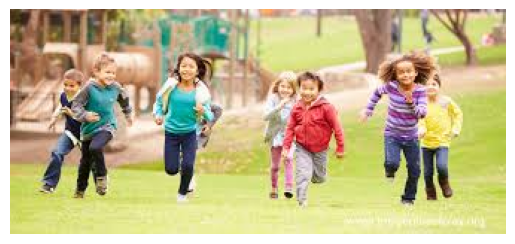

In [36]:
# Example usage:
image_path = '/content/images (1).jpeg'

# First, recreate the VGG16 feature extractor model (the same one you used during training)
resnet_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

# Generate caption
caption = generate_caption(
    image_path=image_path,
    model=model,  # your trained GRU captioning model
    resnet_model=resnet_model,  # the VGG16 feature extractor
    tokenizer=tokenizer,
    max_len=max_len
)
caption = clean_caption(caption)
# Display results
print("Generated Caption:", caption)
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

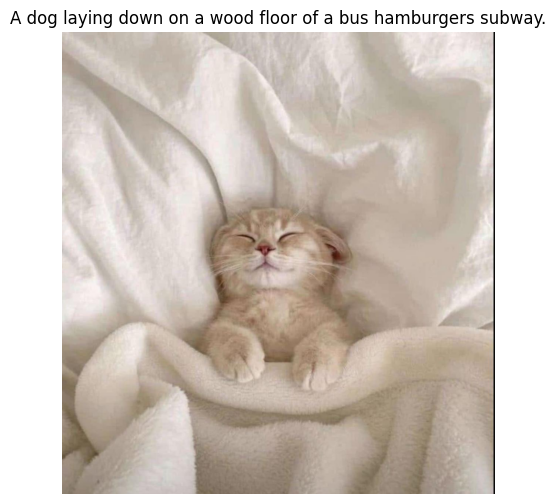

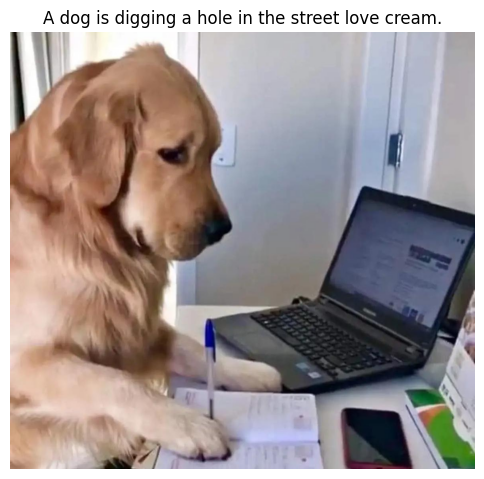

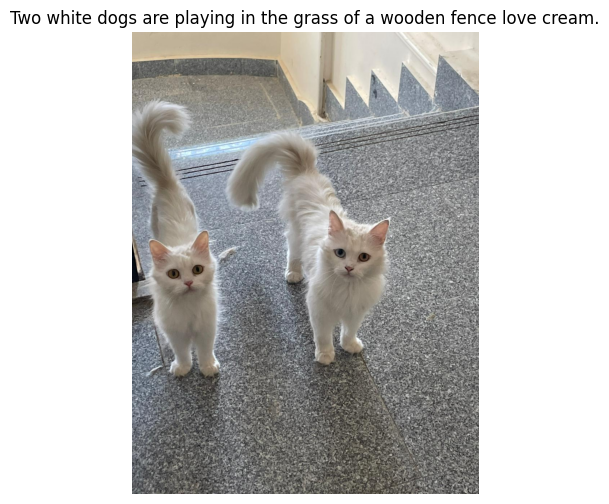

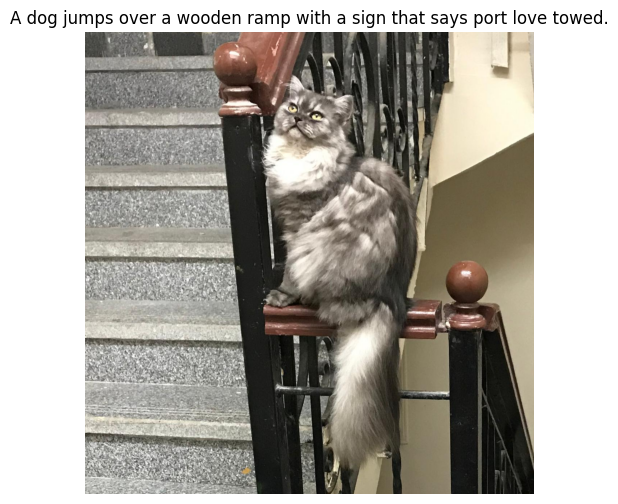

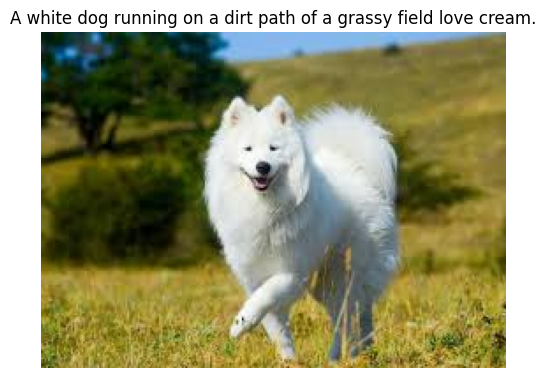

Generated Caption: A white dog running on a dirt path of a grassy field love cream.


In [35]:
from tensorflow.keras.applications import ResNet50
from PIL import Image
import matplotlib.pyplot as plt

# Example usage
image_paths = [
    '/content/8 this.jpg',
    '/content/9 this.jpg',
    '/content/cat.jpg',
    '/content/cats.jpg',
    '/content/images.jpeg'
]

# Load the ResNet50 feature extractor

# Loop over each image
for image_path in image_paths:
    # Generate caption
    caption = generate_caption(
        image_path=image_path,
        model=model,              # your trained GRU captioning model
        resnet_model=resnet_model, # your feature extractor
        tokenizer=tokenizer,
        max_len=max_len
    )

    # Clean the generated caption
    caption = clean_caption(caption)

    # Display the image and its caption
    img = Image.open(image_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()

  # Recreate the ResNet50 model for feature extraction (inference time)
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

# Generate caption
caption = generate_caption(image_path, modell, resnet_model, tokenizer, max_len)

# Clean and print it
cleaned_caption = clean_caption(caption)
print("Generated Caption:", cleaned_caption)


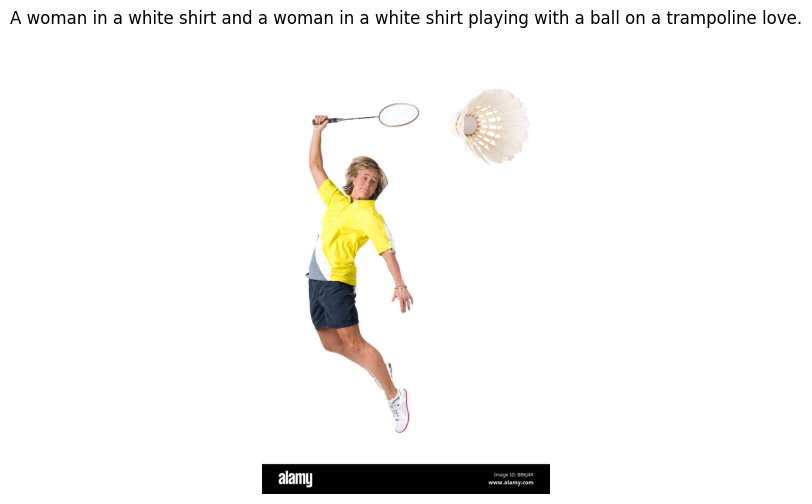

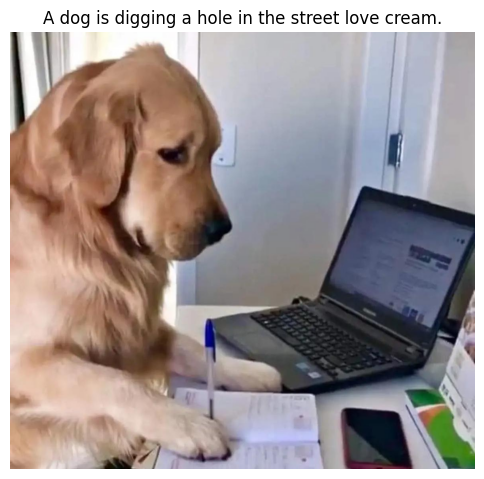

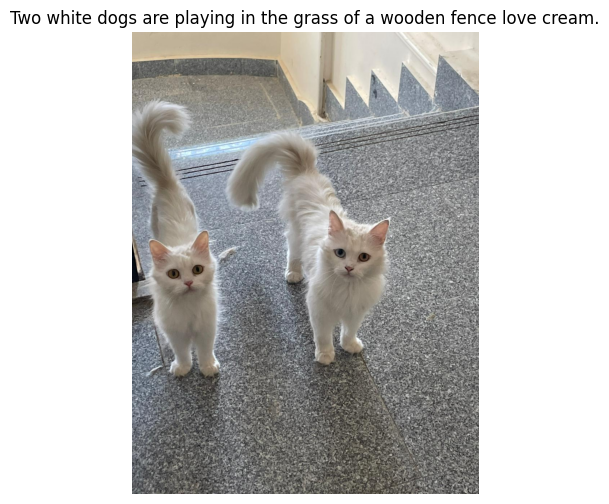

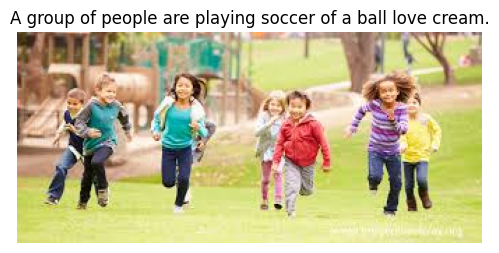

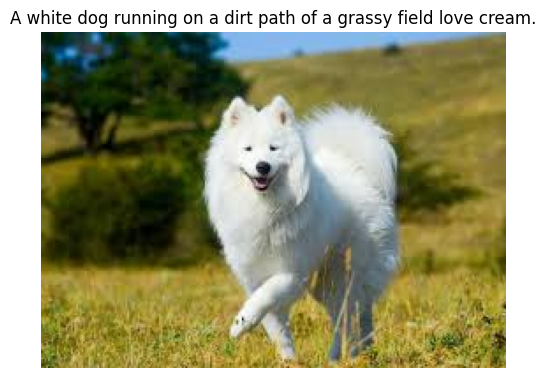

Generated Caption: A white dog running on a dirt path of a grassy field love cream.


In [38]:
from tensorflow.keras.applications import ResNet50
from PIL import Image
import matplotlib.pyplot as plt

# Example usage
image_paths = [
    '/content/iiiiiiiii.jpg',
    '/content/9 this.jpg',
    '/content/cat.jpg',
    '/content/images (1).jpeg',
    '/content/images.jpeg'
]

# Load the ResNet50 feature extractor

# Loop over each image
for image_path in image_paths:
    # Generate caption
    caption = generate_caption(
        image_path=image_path,
        model=model,              # your trained GRU captioning model
        resnet_model=resnet_model, # your feature extractor
        tokenizer=tokenizer,
        max_len=max_len
    )

    # Clean the generated caption
    caption = clean_caption(caption)

    # Display the image and its caption
    img = Image.open(image_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()

  # Recreate the ResNet50 model for feature extraction (inference time)
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

# Generate caption
caption = generate_caption(image_path, modell, resnet_model, tokenizer, max_len)

# Clean and print it
cleaned_caption = clean_caption(caption)
print("Generated Caption:", cleaned_caption)
